In [ ]:
#! pip install snscrape==0.4.3.20220106

In [ ]:
# import all required libraries
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import snscrape.modules.twitter as sntwitter
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from bs4 import BeautifulSoup # documentation available at : www.crummy.com/software/BeautifulSoup/bs4/doc/
import requests # sends http requests and access the page : docs.python-requests.org/en/latest/
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings("ignore")
import math
import matplotlib.pyplot as plt
import datetime


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


## Scraping Tweets for hashtags #FairandLovely and #GlowandLovely, #BoycottDove

Skin lightening creams have often shown advertisements with people — mostly women — with dark skin as having problems when it comes to finding jobs, getting married and generally being accepted by society. This resulted in views that such advertising was communicating discrimination as a result of skin color. 
  
On 26th June 2020, 'Fair & Lovely', one of such skin lightening brands was renamed to 'Glow & Lovely" by dropping the word 'fair. We will try to analyse the impact of such rebranding as a marketing action by collecting tweets having the hashtag #FairandLovely and #GlowandLively for the period of 6 months prior and post this rebranding date.

> # Boycott Dove

In [ ]:
from_date = "2017-07-01" # Declare a start date
end_date = "2018-03-31"  # Declare a end date
count = 10000    # The maximum number of tweets
num=1          #counter
tweets_list_keyword = []    # A list used to store the retuned results for user search
key_word = "#BoycottDove"  # Declare the key word used to search tweets
#### Scraping tweets from a text search query ####
command_keyword = key_word+' since:'+from_date+' until:'+end_date + ' include:nativeretweets'  # Define a string command for Scraper Api
#print("Scraping data for keyword:",key_word)
for i,tweet in enumerate(sntwitter.TwitterSearchScraper(command_keyword).get_items()):
    if tweet.lang=='en' and len(tweet.content)>14: #and tweet.coordinates != None 
        if num>count:
            break
        if tweet.coordinates!=None:
            tweets_list_keyword.append([tweet.date.strftime("%m/%d/%Y"),tweet.id, tweet.content, tweet.user.username, tweet.url, tweet.user.location, tweet.user.followersCount,tweet.user.friendsCount, tweet.user.listedCount, tweet.user.statusesCount, tweet.likeCount, tweet.retweetCount, tweet.replyCount, tweet.retweetedTweet, tweet.inReplyToUser, tweet.mentionedUsers, tweet, tweet.coordinates.latitude, tweet.coordinates.longitude]) # Append returned results to list
        else:
            tweets_list_keyword.append([tweet.date.strftime("%m/%d/%Y"),tweet.id, tweet.content, tweet.user.username, tweet.url, tweet.user.location, tweet.user.followersCount,tweet.user.friendsCount, tweet.user.listedCount, tweet.user.statusesCount, tweet.likeCount, tweet.retweetCount, tweet.replyCount, tweet.retweetedTweet, tweet.inReplyToUser, tweet.mentionedUsers, tweet, np.nan, np.nan]) # Append returned results to list
        num = len(tweets_list_keyword)

In [ ]:
# Create a dataframe from the tweets list above 
tweets_bd = pd.DataFrame(tweets_list_keyword, columns=['Date','Tweet Id', 'Text', 'Username', 'url', 'User Location', 'User Follower Count', 'User Following Count', 'User Listed Count', 'User Posts Count', 'Tweet Likes Count','Tweet Retweet count', 'Tweet Reply Count', 'Retweeted Tweet', 'Reply To User', 'Mentioned Users','Tweet', 'Tweet latitude', 'Tweet longitude'])

Evaluate additional fields for the Tweet

In [ ]:
# Tweet Content Type
tweets_bd["ContentType"] = np.where( tweets_bd['Mentioned Users'].isna() & tweets_bd['Retweeted Tweet'].isna() & tweets_bd['Reply To User'].isna() ,"Tweet","NonTweet")

### Pre Processing for Sentiment analysis and topic modelling

In [ ]:
Lemma = WordNetLemmatizer()
list_stopwords = ['#boycottdove']

stops = set(stopwords.words('english'))
stops = stops.union(list_stopwords)

In [ ]:
def clean_review(review):   
    # remove html tags
    raw_review = BeautifulSoup(review, 'html.parser').get_text()
    # Extract alphanumeric text
    letters_only = re.sub('[^0-9a-zA-Z#]', ' ', raw_review)
    # lower case letters
    words = letters_only.lower().split()
    # remove Stopwords 
    meaningful_words = [w for w in words if not w in stops]
    # Stemming/lemmitization
    #stemming_words = [stemmer.stem(w) for w in meaningful_words]       
    lemma = WordNetLemmatizer()
    #dont cosider repeated words
    lemm_words = list(set([lemma.lemmatize(w) for w in meaningful_words]))
    # space join words
    return( ' '.join(lemm_words))

In [ ]:
tweets_bd['Text_clean'] = tweets_bd['Text'].apply(clean_review)

In [ ]:
tweets_bd.to_csv("BoycottDove_allfields_data.csv", index=False)

## Separate data into 3 time frames 

In [ ]:
tweets_bd_all= pd.read_csv("BoycottDove_allfields_data.csv")

In [ ]:
# head = tweets_bd_all['Date'].value_counts().sort_index(ascending=False)
# plt.figure(figsize = (15,8))
# plt.xticks(rotation=45)
# ax = sns.lineplot(head.index, head.values)

In [ ]:
tweets_bd_all["Date"]=tweets_bd_all["Date"]

In [ ]:
tweets_bd_inception = tweets_bd_all[(tweets_bd_all["Date"]=="10/07/2017") | (tweets_bd_all["Date"]=="10/06/2017")]
tweets_bd_inception.to_csv("Inception_BoyCottDove.csv", index=False)

In [ ]:
tweets_bd_explosion = tweets_bd_all[(tweets_bd_all["Date"]=="10/08/2017") | (tweets_bd_all["Date"]=="10/09/2017")]
tweets_bd_explosion.to_csv("Explosion_BoyCottDove.csv",index=False)

In [ ]:
tweets_bd_decay= tweets_bd_all[(tweets_bd_all["Date"]>="10/10/2017") ]
tweets_bd_decay.to_csv("Decay_BoyCottDove.csv",index=False)

### Pre Processing for nodeXL
Extract Users from Tweet, Retweet, Mentions and Replies

In [ ]:

tweets_bd_10cols = pd.DataFrame(columns=["User1", "User2","ContentType", "User1 Follower Count", "User1 latitude", "User1 longitude", "User2 Follower Count", "User2 latitude", "User2 longitude","Date"])
for index, row in tweets_bd.iterrows():    
    #print(index)
    col1=row["Username"]
    col3=row['ContentType']
    col2 = ""   
    col4 = row["User Follower Count"]
    col5 = row["Tweet latitude"]
    col6 = row["Tweet longitude"]
    col10=row["Date"]
    #tweetid=row["Date"]

    if row["Retweeted Tweet"] is not None:
        retweeted_user = row['Retweeted Tweet'].user
        col2 = retweeted_user.username
        for j, tweet in enumerate(sntwitter.TwitterSearchScraper('from:'+col2).get_items()):
            if tweet.user.followersCount!=None:
                col7 = tweet.user.followersCount
                break
            else:
                col7=np.nan
        if tweet.coordinates!=None:
            col8 = tweet.coordinates.latitude 
            col9 = tweet.coordinates.longitude
        else:
            col8 = np.nan
            col9 = np.nan

        tweets_bd_10cols.loc[tweets_bd_10cols.shape[0]]= [col1,col2,col3, col4, col5, col6, col7, col8, col9,col10]
        tweets_bd_10cols.loc[tweets_bd_10cols.shape[0]]= [col2,col2,'Tweet', col4, col5, col6, col7, col8, col9]
    elif row['Mentioned Users'] is not None:
            #print(row['Mentioned Users'])
            for i in row['Mentioned Users']:
                col2 = i.username

                try:

                    for j, tweet in enumerate(sntwitter.TwitterSearchScraper('from:'+col2).get_items()):
                        if tweet.user.followersCount!=None:
                            col7 = tweet.user.followersCount
                            break
                        else:
                            col7=np.nan

                    if tweet.coordinates!=None:
                        col8 = tweet.coordinates.latitude 
                        col9 = tweet.coordinates.longitude
                    else:
                        col8 = np.nan
                        col9 = np.nan
                except:
                    col7=np.nan
                    col8=np.nan
                    col9=np.nan
                tweets_bd_10cols.loc[tweets_bd_10cols.shape[0]]= [col1,col2,col3, col4, col5, col6, col7, col8, col9,col10]
    elif row['Reply To User'] is not None:
            col2 = row['Reply To User'].username

            for j, tweet in enumerate(sntwitter.TwitterSearchScraper('from:'+col2).get_items()):
                if tweet.user.followersCount!=None:
                    col7 = tweet.user.followersCount
                    break
                else:
                    col7=np.nan
            if tweet.coordinates!=None:
                col8 = tweet.coordinates.latitude 
                col9 = tweet.coordinates.longitude
            else:
                col8 = np.nan
                col9 = np.nan
            tweets_bd_10cols.loc[tweets_bd_10cols.shape[0]]= [col1,col2,col3, col4, col5, col6, col7, col8, col9,col10]
    else:

            tweets_bd_10cols.loc[tweets_bd_10cols.shape[0]]= [col1,col1,col3, col4, col5, col6, col4, col5, col6, col10]            

Export Data in the format required for Node XL

In [ ]:
tweets_bd_10cols.to_csv("BoycottDove_graph_data.csv", index=False)

In [ ]:
tweets_bd_10cols = pd.read_csv("BoycottDove_graph_data.csv")

In [ ]:
tweets_bd_inception = tweets_bd_10cols[(tweets_bd_10cols["Date"]=="10/07/2017") | (tweets_bd_10cols["Date"]=="10/06/2017")]
tweets_bd_inception.to_csv("Inception_BoycottDove_graph_data.csv", index=False)

In [ ]:
tweets_bd_explosion = tweets_bd_10cols[(tweets_bd_10cols["Date"]=="10/08/2017") | (tweets_bd_10cols["Date"]=="10/09/2017")]
tweets_bd_explosion.to_csv("Explosion_BoycottDove_graph_data.csv",index=False)

In [ ]:
tweets_bd_decay= tweets_bd_10cols[(tweets_bd_10cols["Date"]>="10/10/2017") ]
tweets_bd_decay.to_csv("Decay_BoycottDove_graph_data.csv",index=False)

In [ ]:
#tweets_bd_10cols[tweets_bd_10cols["User1"]!=tweets_bd_10cols["User2"]].to_csv("BoycottDove_graph_data_incep.csv", index=False)

# Boycott Dove Topic Analysis

### Import the tweets extracted from scraping for Boycott Dove 

In [ ]:
from google.colab import files
upload = files.upload()

Saving BoycottDove_allfields_data.csv to BoycottDove_allfields_data.csv


In [ ]:
import pandas as pd
# uses default alpha and beta values
boycott_dove_tweets=pd.read_csv("BoycottDove_allfields_data.csv")

In [ ]:
#checking for nulls if present any
print("Number of rows with any of the empty columns:")
boycott_dove_tweets=boycott_dove_tweets.dropna(axis=0, subset=['Text_clean'])
print(boycott_dove_tweets.isnull().sum())

Number of rows with any of the empty columns:
Date                       0
Tweet Id                   0
Text                       0
Username                   0
url                        0
User Location            310
User Follower Count        0
User Following Count       0
User Listed Count          0
User Posts Count           0
Tweet Likes Count          0
Tweet Retweet count        0
Tweet Reply Count          0
Retweeted Tweet         1575
Reply To User           1181
Mentioned Users          680
Tweet                      0
Tweet latitude          1481
Tweet longitude         1481
ContentType                0
Text_clean                 0
dtype: int64


In [ ]:
boycott_dove_tweets['Text_clean'] #needs further pre-processing

0       http #resist nfl law changed co #vote like #bo...
1       http still mad dovemencare co campaign fwy dov...
2       http #resist 224 nfl co #vote #boycottnfl #bla...
3       urged http #internationalwomensday2018 co #8m ...
4       bwrap1 http szl1wkxfp5 againstrape unilever co...
                              ...                        
1570         skincare breastfeeding dove advert got awful
1571    http one marketing campaign terrible #national...
1572            epic #boycottbabydove dove fail makesmilk
1573               http 9pofiambv7 disgusting dove wtf co
1574    wizyhzyuxf legally http co 2010 meant public e...
Name: Text_clean, Length: 1575, dtype: object

#### Clean the tweets to remove unnecessary stop words

In [ ]:
boycott_dove_tweets['Text_clean'] = boycott_dove_tweets['Text_clean'].apply(clean_tweet)

In [ ]:
boycott_dove_tweets.Text_clean 

0       #resist wire like feel trying murder #register...
1                                    dove campaign racist
2                  read #resist #register stop #vote 3121
3       #rohingya support urged #rape #iwd2018 #unilev...
4       genocide rohingya outside disinvest yesterday ...
                              ...                        
1570                           advert awful dove skincare
1571         terrible marketing dove campaign middle nice
1572                             epic dove fail makesmilk
1573                                                 dove
1574    right 2010 legally appeal meant know dove equa...
Name: Text_clean, Length: 1575, dtype: object

#### Get the columns to be used for topic modelling

In [ ]:
# input: Username, Text_clean, 3
user_name = input('Provide the column name for user names: ')
user_tweet = input('Provide the column name for user tweets: ')
ntopics= input('Provide the number of latent topics to be estimated: ')

Provide the column name for user names: user_name
Provide the column name for user tweets: user_tweet
Provide the number of latent topics to be estimated: 3



##### Tokenize the words and find the topics

In [ ]:
vec_words = CountVectorizer(tokenizer=tokenize_text,stop_words=stopwords,decode_error='ignore')
total_features_words = vec_words.fit_transform(boycott_dove_tweets['Text_clean'])

print(total_features_words.shape)

(1575, 2121)


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  % sorted(inconsistent)


In [ ]:
model = lda.LDA(n_topics=int(ntopics), n_iter=500, random_state=1)
model.fit(total_features_words)

INFO:lda:n_documents: 1575
INFO:lda:vocab_size: 2121
INFO:lda:n_words: 8586
INFO:lda:n_topics: 3
INFO:lda:n_iter: 500
INFO:lda:<0> log likelihood: -78223
INFO:lda:<10> log likelihood: -64199
INFO:lda:<20> log likelihood: -63490
INFO:lda:<30> log likelihood: -63098
INFO:lda:<40> log likelihood: -63015
INFO:lda:<50> log likelihood: -62696
INFO:lda:<60> log likelihood: -62730
INFO:lda:<70> log likelihood: -62658
INFO:lda:<80> log likelihood: -62749
INFO:lda:<90> log likelihood: -62615
INFO:lda:<100> log likelihood: -62732
INFO:lda:<110> log likelihood: -62627
INFO:lda:<120> log likelihood: -62646
INFO:lda:<130> log likelihood: -62523
INFO:lda:<140> log likelihood: -62580
INFO:lda:<150> log likelihood: -62438
INFO:lda:<160> log likelihood: -62487
INFO:lda:<170> log likelihood: -62452
INFO:lda:<180> log likelihood: -62387
INFO:lda:<190> log likelihood: -62429
INFO:lda:<200> log likelihood: -62313
INFO:lda:<210> log likelihood: -62283
INFO:lda:<220> log likelihood: -62269
INFO:lda:<230> log 

In [ ]:
topic_word = model.topic_word_
doc_topic=model.doc_topic_
doc_topic=pd.DataFrame(doc_topic)
boycott_dove_tweets=boycott_dove_tweets.join(doc_topic)

##### Find the top words in each topic

In [ ]:
stops = ["boycott","dove"]
topics = ['1', '2', '3']

n_top_words = 20
vocab = vec_words.get_feature_names_out()
for i, topic_dist in enumerate(topic_word):
  topic_words = np.array(vocab)[np.argsort(topic_dist)][:-n_top_words:-1]
  topic_words = [word for word in topic_words if not word in stops]
  print('{}: {}'.format(topics[i], ' '.join(topic_words)))

1: racist woman black marketing unilever white company apology buyblack product need people racism team wrong facebook campaign
2: racist product mark skin black normal unilever missed dark racism soap company time support dovead brand think
3: product black soap racist apology skin people racism know woman dirty buying away good color like think love


##### Save the final topics and words to csv

In [ ]:
boycott_dove=pd.DataFrame()
for i in range(int(ntopics)):
    topic="topic_"+str(i)
    boycott_dove[topic]=boycott_dove_tweets.groupby([boycott_dove_tweets.Username])[i].mean()

boycott_dove=boycott_dove.reset_index()
topics=pd.DataFrame(topic_word)
topics.columns=vec_words.get_feature_names()
topics1=topics.transpose()
topics1.drop(stops, inplace=True)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# Extract topics and word frequencies as csv 

topics1.to_excel("boycottdove_topic_word_dist.xlsx")
boycott_dove.to_excel("boycottdove_user_topic_dist.xlsx",index=False)

## Visualization

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:126: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):


In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
import umap.umap_ as umap
from spacy.lang.en import English
nlp = English()

def tokenizer(text):
    return [token.lemma_.lower() for token in nlp(text) if not token.is_stop and not token.is_punct]



vectorizer = TfidfVectorizer(min_df=10, max_features=10000, tokenizer=tokenizer, ngram_range=(1, 2))
vz = vectorizer.fit_transform(boycott_dove_tweets['Text_clean'])

svd_model = TruncatedSVD(n_components=50)
#svd_tfidf = svd_model.fit_transform(vectorizer)

umap_model = umap.UMAP(n_components=2)
umap_tfidf = umap_model.fit_transform(vz)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: Sele

In [ ]:
#import pyLDAvis
#import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(model, total_features_words, vec_words)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.146478  0.214695       1        1  37.143714
1     -0.121436 -0.228504       2        1  32.334302
0      0.267914  0.013808       3        1  30.521985, topic_info=           Term       Freq      Total Category  logprob  loglift
1146       mark  54.000000  54.000000  Default  30.0000  30.0000
1151  marketing  42.000000  42.000000  Default  29.0000  29.0000
1288     normal  42.000000  42.000000  Default  28.0000  28.0000
1191     missed  34.000000  34.000000  Default  27.0000  27.0000
273    buyblack  32.000000  32.000000  Default  26.0000  26.0000
...         ...        ...        ...      ...      ...      ...
804       going  13.785940  30.747166   Topic3  -5.2475   0.3846
1679       shit  11.817926  27.780505   Topic3  -5.4015   0.3320
1902    thought  11.817926  27.782605   Topic3  -5.4015   0.3319
559      dovead  11.817926  36.748245   Topic3  -5.4015   0.0522
1031       know  11.817926  45.720449   Topic3  -5.4015  -0.1662

[189 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
11        2  1.002022     2017
50        2  1.001460  african
56        3  1.012424   agency
59        3  1.012848    agree
98        1  1.001328  anymore
...     ...       ...      ...
2078      1  0.411737    woman
2078      3  0.586414    woman
2093      3  1.014973    wrong
2103      1  0.358029     year
2103      2  0.644452     year

[185 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

> # FairAndLovely to GlowAndLovely

## Fair and Lovely

In [ ]:
from_date = "2019-01-01" # Declare a start date
end_date = '2022-04-30'  # Declare a end date
count = 10000    # The maximum number of tweets
num=1          #counter
tweets_list_keyword = []    # A list used to store the retuned results for user search
key_word = "#FairandLovely"  # Declare the key word used to search tweets
#### Scraping tweets from a text search query ####
command_keyword = key_word+' since:'+from_date+' until:'+end_date + ' include:nativeretweets'  # Define a string command for Scraper Api
#print("Scraping data for keyword:",key_word)
for i,tweet in enumerate(sntwitter.TwitterSearchScraper(command_keyword).get_items()):
    if tweet.lang=='en' and len(tweet.content)>14: #and tweet.coordinates != None 
        if num>count:
            break
        if tweet.coordinates!=None:
            tweets_list_keyword.append([tweet.date,tweet.id, tweet.content, tweet.user.username, tweet.url, tweet.user.location, tweet.user.followersCount,tweet.user.friendsCount, tweet.user.listedCount, tweet.user.statusesCount, tweet.likeCount, tweet.retweetCount, tweet.replyCount, tweet.retweetedTweet, tweet.inReplyToUser, tweet.mentionedUsers, tweet, tweet.coordinates.latitude, tweet.coordinates.longitude]) # Append returned results to list
        else:
            tweets_list_keyword.append([tweet.date,tweet.id, tweet.content, tweet.user.username, tweet.url, tweet.user.location, tweet.user.followersCount,tweet.user.friendsCount, tweet.user.listedCount, tweet.user.statusesCount, tweet.likeCount, tweet.retweetCount, tweet.replyCount, tweet.retweetedTweet, tweet.inReplyToUser, tweet.mentionedUsers, tweet, np.nan, np.nan]) # Append returned results to list
        num = len(tweets_list_keyword)
        
# Create a dataframe from the tweets list above 
tweets_FairandLovely = pd.DataFrame(tweets_list_keyword, columns=['Datetime','Tweet Id', 'Text', 'Username', 'url', 'User Location', 'User Follower Count', 'User Following Count', 'User Listed Count', 'User Posts Count', 'Tweet Likes Count','Tweet Retweet count', 'Tweet Reply Count', 'Retweeted Tweet', 'Reply To User', 'Mentioned Users','Tweet', 'Tweet latitude', 'Tweet longitude'])

Evaluate additional fields for the Tweet

In [ ]:
# Tweet Content Type
tweets_FairandLovely["ContentType"] = np.where( tweets_FairandLovely['Mentioned Users'].isna() & tweets_FairandLovely['Retweeted Tweet'].isna() & tweets_FairandLovely['Reply To User'].isna() ,"Tweet","NonTweet")

### Pre Processing for Sentiment analysis and topic modelling

In [ ]:
Lemma = WordNetLemmatizer()
list_stopwords = ['#fairandlovely', "#glowandlovely"]

stops = set(stopwords.words('english'))
stops = stops.union(list_stopwords)

In [ ]:
def clean_review(review):   
    # remove html tags
    raw_review = BeautifulSoup(review, 'html.parser').get_text()
    # Extract alphanumeric text
    letters_only = re.sub('[^0-9a-zA-Z#]', ' ', raw_review)
    # lower case letters
    words = letters_only.lower().split()
    # remove Stopwords 
    meaningful_words = [w for w in words if not w in stops]
    # Stemming/lemmitization
    #stemming_words = [stemmer.stem(w) for w in meaningful_words]       
    lemma = WordNetLemmatizer()
    #dont cosider repeated words
    lemm_words = list(set([lemma.lemmatize(w) for w in meaningful_words]))
    # space join words
    return( ' '.join(lemm_words))

In [ ]:
tweets_FairandLovely['Text_clean'] = tweets_FairandLovely['Text'].apply(clean_review)

In [ ]:
tweets_FairandLovely.to_csv("FairandLovely_allfields_data.csv", index=False)

## Glow And Lovely

In [ ]:
from_date = "2020-06-01" # Declare a start date
end_date = '2022-04-30'  # Declare a end date
count = 2000  # The maximum number of tweets  
num=1        #counter
tweets_list_keyword = []    # A list used to store the retuned results for user search
key_word = "#GlowandLovely"  # Declare the key word used to search tweets
#### Scraping tweets from a text search query ####
command_keyword = key_word+' since:'+from_date+' until:'+end_date + ' include:nativeretweets'  # Define a string command for Scraper Api
print("Scraping data for keyword:",key_word)
for i,tweet in enumerate(sntwitter.TwitterSearchScraper(command_keyword).get_items()):
    if tweet.lang=='en' and len(tweet.content)>14: #and tweet.coordinates != None 
        if num>count:
            break
        if tweet.coordinates!=None:
            tweets_list_keyword.append([tweet.date,tweet.id, tweet.content, tweet.user.username, tweet.url, tweet.user.location, tweet.user.followersCount,tweet.user.friendsCount, tweet.user.listedCount, tweet.user.statusesCount, tweet.likeCount, tweet.retweetCount, tweet.replyCount, tweet.retweetedTweet, tweet.inReplyToUser, tweet.mentionedUsers, tweet, tweet.coordinates.latitude, tweet.coordinates.longitude]) # Append returned results to list
        else:
            tweets_list_keyword.append([tweet.date,tweet.id, tweet.content, tweet.user.username, tweet.url, tweet.user.location, tweet.user.followersCount,tweet.user.friendsCount, tweet.user.listedCount, tweet.user.statusesCount, tweet.likeCount, tweet.retweetCount, tweet.replyCount, tweet.retweetedTweet, tweet.inReplyToUser, tweet.mentionedUsers, tweet, np.nan, np.nan]) # Append returned results to list
        num = len(tweets_list_keyword)
        
# Create a dataframe from the tweets list above 
tweets_GlowandLovely = pd.DataFrame(tweets_list_keyword, columns=['Datetime','Tweet Id', 'Text', 'Username', 'url', 'User Location', 'User Follower Count', 'User Following Count', 'User Listed Count', 'User Posts Count', 'Tweet Likes Count','Tweet Retweet count', 'Tweet Reply Count', 'Retweeted Tweet', 'Reply To User', 'Mentioned Users','Tweet', 'Tweet latitude', 'Tweet longitude'])

Scraping data for keyword: #GlowandLovely


Evaluate additional fields for the Tweet

In [ ]:
# Tweet Content Type
tweets_GlowandLovely["ContentType"] = np.where( tweets_GlowandLovely['Mentioned Users'].isna() & tweets_GlowandLovely['Retweeted Tweet'].isna() & tweets_GlowandLovely['Reply To User'].isna() ,"Tweet","NonTweet")

### Pre Processing for Sentiment analysis and topic modelling

In [ ]:
Lemma = WordNetLemmatizer()
list_stopwords = ['#fairandlovely', "#glowandlovely"]

stops = set(stopwords.words('english'))
stops = stops.union(list_stopwords)

In [ ]:
tweets_GlowandLovely['Text_clean'] = tweets_GlowandLovely['Text'].apply(clean_review)

In [ ]:
tweets_GlowandLovely.to_csv("GlowandLovely_allfields_data.csv", index=False)

## FairandLovely data before Re-branding

In [ ]:
# Loading the Fair and Lovely hashtag dataset 

tweets_FairandLovely=pd.read_csv("FairandLovely_allfields_data.csv")
tweets_FairandLovely.head()

,Datetime,Tweet Id,Text,Username,url,User Location,User Follower Count,User Following Count,User Listed Count,User Posts Count,...,Tweet Retweet count,Tweet Reply Count,Retweeted Tweet,Reply To User,Mentioned Users,Tweet,Tweet latitude,Tweet longitude,ContentType,Text_clean
0,2022-03-23 01:29:32+00:00,1506442993594781696,@myraemacdonald Since it’s a privileged White ...,thepatriotfiles,https://twitter.com/thepatriotfiles/status/150...,USA,273,1295,12,26353,...,1,0,NaN,https://twitter.com/myraemacdonald,"[User(username='myraemacdonald', id=14889248, ...",https://twitter.com/thepatriotfiles/status/150...,NaN,NaN,NonTweet,person need since saying obviously privileged ...
1,2022-03-19 14:06:52+00:00,1505184030488412160,@captsanthoshkc When you have #lakmefashionwee...,Thegallatekid,https://twitter.com/Thegallatekid/status/15051...,At my home,7,8,0,213,...,0,0,NaN,https://twitter.com/captsanthoshkc,"[User(username='captsanthoshkc', id=81759496, ...",https://twitter.com/Thegallatekid/status/15051...,NaN,NaN,NonTweet,#lakmefashionweek captsanthoshkc stop ad runni...
2,2022-03-14 13:46:07+00:00,1503366868261752834,Its trending soo ......\n#fairandlovely https:...,hrshuwu_fanboy7,https://twitter.com/hrshuwu_fanboy7/status/150...,"he / him , 19 , bangtwice",3452,2600,3,16389,...,0,1,NaN,NaN,NaN,https://twitter.com/hrshuwu_fanboy7/status/150...,NaN,NaN,Tweet,soo http co nnm2xnegvd trending
3,2022-03-06 09:14:17+00:00,1500399357170192385,"@arunbothra After #FairAndLovely, Dainik Bhask...",chanchalsTweet,https://twitter.com/chanchalsTweet/status/1500...,"Bolangir, Odisha",1018,411,0,7457,...,0,0,NaN,https://twitter.com/arunbothra,"[User(username='arunbothra', id=76724591, disp...",https://twitter.com/chanchalsTweet/status/1500...,NaN,NaN,NonTweet,row 2nd dainik arunbothra bhaskar
4,2022-02-28 18:29:32+00:00,1498364763436425219,@GabbbarSingh You have to be fair and wife has...,Vishalmahesh,https://twitter.com/Vishalmahesh/status/149836...,"London, England",139,758,4,1025,...,0,0,NaN,https://twitter.com/GabbbarSingh,"[User(username='GabbbarSingh', id=108391251, d...",https://twitter.com/Vishalmahesh/status/149836...,NaN,NaN,NonTweet,fair lovely wife gabbbarsingh


In [ ]:
# Changing the datatype of datetime column

tweets_FairandLovely["Datetime"] = pd.to_datetime(tweets_FairandLovely['Datetime'])
# Fetching reviews before rebranding took place

start_date= "2019-01-05"
end_date = "2020-06-25"
df_FandL = tweets_FairandLovely[(tweets_FairandLovely['Datetime'] > start_date) & (tweets_FairandLovely['Datetime'] <= end_date)]

## Combining FairandLovely and GlowandLovely data after Re-branding

In [ ]:
# Reading reviews with hashtag GlowAndLovely

tweets_GlowandLovely = pd.read_csv("GlowandLovely_allfields_data.csv")

In [ ]:
# Setting datetime column's type to datetime 

tweets_GlowandLovely["Datetime"] = pd.to_datetime(tweets_GlowandLovely['Datetime'])
# With the earliest date as 25th June, 2020, we set this as the date the brand was renamed to Glow And Lovely and
# fetch all reviews then onwards

rebranding_date = "2020-06-25"
df_GandL = tweets_GlowandLovely[tweets_GlowandLovely['Datetime'] > rebranding_date]
df_GandL.shape

# Taking a subset of the original dataframe to perforn sentiment analysis upon
#df_GandL= df_GandL[["Datetime", "Tweet Id", "Username", "Text_clean"]].copy()
#df_GandL.shape

(1027, 21)

In [ ]:
# Fetching tweets with hashtag Fair and Lovely post rebranding

df_FandL_rebrand = tweets_FairandLovely[tweets_FairandLovely['Datetime'] > rebranding_date]
df_FandL_rebrand.shape

# Taking a subset of the original dataframe to perform sentiment analysis upon
#df_FandL_rebrand= df_FandL_rebrand[["Datetime", "Tweet Id", "Username", "Text_clean"]].copy()
#df_FandL_rebrand.shape

(3206, 21)

In [ ]:
# Combining tweets from fair and lovely and glow and lovely

df_post_rebranding = pd.DataFrame()
df_post_rebranding = pd.concat([df_GandL, df_FandL_rebrand], axis=0)
df_post_rebranding.shape

(4233, 21)

# Topic Modelling

In [ ]:
# install the package for topic modelling and import the necessary modules
! pip install lda

     |████████████████████████████████| 351 kB 8.5 MB/s 
     |████████████████████████████████| 99 kB 8.6 MB/s 


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import lda
import pandas as pd
from nltk.tokenize import PunktSentenceTokenizer, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import re
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
from gensim.parsing.preprocessing import remove_stopwords
from nltk.stem import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


# Fair and Lovely Topic Analysis

### Import the tweets extracted from scraping for Fair & Lovely 

In [ ]:
from google.colab import files
upload = files.upload()

Saving FairandLovely_allfields_data.csv to FairandLovely_allfields_data.csv


In [ ]:
import pandas as pd
# uses default alpha and beta values
fairlovely_tweets=pd.read_csv("FairandLovely_allfields_data.csv")

In [ ]:
stopwords=set(stopwords.words('english'))
additional_stopwords= ["http","bit"]
stopwords = stopwords.union(additional_stopwords)

In [ ]:
def clean_tweet(tweet):   
    words = tweet.lower().split()
    # remove Stopwords by nltk
    meaningful_words = [w for w in words if not w in stopwords and len(w) > 3 and len(w) < 10]
    # stopwords removal by spacy (removed since time consuming)
    #meaningful_words = [w for w in meaningful_words if English().vocab[w].is_stop == False]

    # Stemming/lemmitization
    #stemming_words = [stemmer.stem(w) for w in meaningful_words]       
    lemma = WordNetLemmatizer()
    ps =PorterStemmer()
    #dont cosider repeated words
    lemm_words = list(set([lemma.lemmatize(w) for w in meaningful_words]))

    # space join words
    sentence = ( ' '.join(lemm_words))
    return remove_stopwords(sentence)
    

In [ ]:
fairlovely_tweets['Text_clean'] = fairlovely_tweets['Text_clean'].apply(clean_tweet)

In [ ]:
fairlovely_tweets.Text_clean 

0            need india saying obviously person fact white
1                                       stop running sense
2                                                 trending
3                                           bhaskar dainik
4                                         lovely fair wife
                               ...                        
11791    career feel fair #recism skinned areavg woman ...
11792             whitened blackened a8dvql muthalik obama
11793         career fair future skin depend baby marriage
11794                                                     
11795      lovely dark 2s393 called nigeria brand jvbakshi
Name: Text_clean, Length: 11795, dtype: object

#### Get the columns to be used for topic modelling

In [ ]:
# input: Username, Text_clean, 3
user_name = input('Provide the column name for user names: ')
user_tweet = input('Provide the column name for user tweets: ')
ntopics= input('Provide the number of latent topics to be estimated: ')

Provide the column name for user names: user_name
Provide the column name for user tweets: user_tweets
Provide the number of latent topics to be estimated: 3


##### Tokenize the words and find the topics

In [ ]:
word_tokenizer=RegexpTokenizer(r'\w+')
wordnet_lemmatizer = WordNetLemmatizer()

def tokenize_text(version_desc):
    lowercase=version_desc.lower()
    text = wordnet_lemmatizer.lemmatize(lowercase)
    tokens = word_tokenizer.tokenize(text)
    return tokens

vec_words = CountVectorizer(tokenizer=tokenize_text,stop_words=stopwords,decode_error='ignore')
total_features_words = vec_words.fit_transform(fairlovely_tweets['Text_clean'])

print(total_features_words.shape)

(11795, 7947)


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  % sorted(inconsistent)


In [ ]:
model = lda.LDA(n_topics=int(ntopics), n_iter=500, random_state=1)
model.fit(total_features_words)

INFO:lda:n_documents: 11795
INFO:lda:vocab_size: 7947
INFO:lda:n_words: 93253
INFO:lda:n_topics: 3
INFO:lda:n_iter: 500
INFO:lda:<0> log likelihood: -686315
INFO:lda:<10> log likelihood: -531932
INFO:lda:<20> log likelihood: -503146
INFO:lda:<30> log likelihood: -498489
INFO:lda:<40> log likelihood: -498232
INFO:lda:<50> log likelihood: -498296
INFO:lda:<60> log likelihood: -497845
INFO:lda:<70> log likelihood: -497782
INFO:lda:<80> log likelihood: -497777
INFO:lda:<90> log likelihood: -497803
INFO:lda:<100> log likelihood: -497628
INFO:lda:<110> log likelihood: -497024
INFO:lda:<120> log likelihood: -497738
INFO:lda:<130> log likelihood: -497583
INFO:lda:<140> log likelihood: -497721
INFO:lda:<150> log likelihood: -497591
INFO:lda:<160> log likelihood: -497510
INFO:lda:<170> log likelihood: -497695
INFO:lda:<180> log likelihood: -497508
INFO:lda:<190> log likelihood: -497429
INFO:lda:<200> log likelihood: -497426
INFO:lda:<210> log likelihood: -497876
INFO:lda:<220> log likelihood: -4

In [ ]:
topic_word = model.topic_word_
doc_topic=model.doc_topic_
doc_topic=pd.DataFrame(doc_topic)
fairlovely_tweets=fairlovely_tweets.join(doc_topic)

##### Find the top words in each topic

In [ ]:
stops = ["fair","lovely"]

topics = ['1', '2', '3']

n_top_words = 15
vocab = vec_words.get_feature_names_out()
for i, topic_dist in enumerate(topic_word):
  topic_words = np.array(vocab)[np.argsort(topic_dist)][:-n_top_words:-1]
  topic_words = [word for word in topic_words if not word in stops]
  print('{}: {}'.format(topics[i], ' '.join(topic_words)))

1: skin white cream whitening change 300ml milky easy converted fyi arsd staygold pacman lljw
2: cream white skin change whitening easy milky 300ml jscmila jogja meet jmunity chat solo
3: unilever product skin fairness cream india like brand glow news beauty people


##### Save the final topics and words to csv

In [ ]:
fair_lovely=pd.DataFrame()
for i in range(int(ntopics)):
    topic="topic_"+str(i)
    fair_lovely[topic]=fairlovely_tweets.groupby([fairlovely_tweets.Username])[i].mean()

fair_lovely=fair_lovely.reset_index()
topics=pd.DataFrame(topic_word)
topics.columns=vec_words.get_feature_names()
topics1=topics.transpose()
topics1.drop(stops, inplace=True)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# Extract topics and word frequencies as csv 

topics1.to_excel("fair_lovely_topic_word_dist.xlsx")
fair_lovely.to_excel("fair_lovely_user_topic_dist.xlsx",index=False)

## Visualization

In [ ]:
! pip install pyLDAvis
!pip install umap-learn[plot]
!pip install holoviews
!pip install -U ipykernel

     |████████████████████████████████| 1.7 MB 8.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=716be124703730f857311cdc1ce1f341060b64cc3f07d5d3cdde849e6ecdfb0b
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis
     |████████████████████████████████| 86 kB 2.2 MB/s 
     |████████████████████████████████| 1.1 MB 13.7 MB/s 
     |████████████████████████████████| 15.8 MB 35.7 MB/s 
     |████████████████████████████████| 76 kB 5.1 MB/s 
     |████████████████████████████████| 136 kB 40.0 MB/s 
     |████████████████████████████████| 837 kB 43.7 MB/s 
     |████████████████████████████████| 830 kB 48.8 MB/s 
     |████████████████████████████████| 822 kB 47.3 MB/s 
     |█████████████

     |████████████████████████████████| 131 kB 8.8 MB/s 
     |████████████████████████████████| 428 kB 45.3 MB/s 
     |████████████████████████████████| 130 kB 49.7 MB/s 
     |████████████████████████████████| 793 kB 59.0 MB/s 
     |████████████████████████████████| 381 kB 52.2 MB/s 
  Attempting uninstall: tornado
    Found existing installation: tornado 5.1.1
    Uninstalling tornado-5.1.1:
      Successfully uninstalled tornado-5.1.1
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: jupyter-client
    Found existing installation: jupyter-client 5.3.5
    Uninstalling jupyter-client-5.3.5:
      Successfully uninstalled jupyter-client-5.3.5
  Attempting uninstall: ipython
    Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0
  Attempting uninstall: ipyk

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
import umap.umap_ as umap
from spacy.lang.en import English
nlp = English()

def tokenizer(text):
    return [token.lemma_.lower() for token in nlp(text) if not token.is_stop and not token.is_punct]



vectorizer = TfidfVectorizer(min_df=10, max_features=10000, tokenizer=tokenizer, ngram_range=(1, 2))
vz = vectorizer.fit_transform(fairlovely_tweets['Text_clean'])

svd_model = TruncatedSVD(n_components=50)
#svd_tfidf = svd_model.fit_transform(vectorizer)

umap_model = umap.UMAP(n_components=2)
umap_tfidf = umap_model.fit_transform(vz)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(model, total_features_words, vec_words)

INFO:root:Generating grammar tables from /usr/lib/python3.7/lib2to3/Grammar.txt
INFO:root:Generating grammar tables from /usr/lib/python3.7/lib2to3/PatternGrammar.txt
/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.422515 -0.000031       1        1  48.901383
0     -0.212538 -0.007750       2        1  27.541337
1     -0.209977  0.007782       3        1  23.557280, topic_info=           Term         Freq        Total Category  logprob  loglift
7748      white  5921.000000  5921.000000  Default  30.0000  30.0000
7752  whitening  5805.000000  5805.000000  Default  29.0000  29.0000
2260       easy  5656.000000  5656.000000  Default  28.0000  28.0000
4603      milky  5653.000000  5653.000000  Default  27.0000  27.0000
71        300ml  5653.000000  5653.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
4526       meet    20.036273    41.011381   Topic3  -6.9998   0.7294
348     amazing    12.407040    35.377839   Topic3  -7.4791   0.3979
3034      greet     6.685115    17.681769   Topic3  -8.0975   0.4731
7138      thank    13.360694    74.249620   Topic3  -7.4050  -0.2694
1563       come    12.407040   102.233485   Topic3  -7.4791  -0.6633

[146 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
6         2  0.936889      1080i
9         2  0.950193       10pm
71        2  0.545326      300ml
71        3  0.454586      300ml
306       2  0.954712  aldoakira
...     ...       ...        ...
7752      3  0.455051  whitening
7772      2  0.956988      willy
7808      1  1.001992      woman
7824      1  0.998707       word
7850      2  0.956988  wrestling

[124 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

#### Clean the tweets to remove unnecessary stop words

In [ ]:
fairlovely_tweets['Text_clean'] #needs further pre-processing

0        privileged saying myraemacdonald backsliding o...
1        ad day every running non sense stop captsantho...
2                          soo nnm2xnegvd co http trending
3                        bhaskar dainik row arunbothra 2nd
4                            gabbbarsingh lovely wife fair
                               ...                        
11791    alright bit social ly feel areavg career skinn...
11792    a8dvql ly krishashok #blacklabel whitened blac...
11793    marriage skin even alexandermcnabb career futu...
11794                                   u dat shewolfhudhu
11795    bit ly 2s393 called lovely brand jvbakshi nige...
Name: Text_clean, Length: 11795, dtype: object

In [ ]:
#checking for nulls if present any
print("Number of rows with any of the empty columns:")
fairlovely_tweets=fairlovely_tweets.dropna(axis=0, subset=['Text_clean'])
print(fairlovely_tweets.isnull().sum())

Number of rows with any of the empty columns:
Datetime                    0
Tweet Id                    0
Text                        0
Username                    0
url                         0
User Follower Count         0
User Following Count        0
User Listed Count           0
User Posts Count            0
Tweet Likes Count           0
Tweet Retweet count         0
Tweet Reply Count           0
Retweeted Tweet         11795
Reply To User           10907
Mentioned Users          9641
Tweet                       0
Tweet latitude          11539
Tweet longitude         11539
ContentType                 0
Text_clean                  0
dtype: int64


# Glow & Lovely Topic Analysis

### Import the tweets extracted from scraping for Glow & Lovely 

In [ ]:
from google.colab import files
upload = files.upload()

Saving GlowandLovely_allfields_data.csv to GlowandLovely_allfields_data.csv


In [ ]:
import pandas as pd
# uses default alpha and beta values
glowlovely_tweets=pd.read_csv("GlowandLovely_allfields_data.csv")

In [ ]:
#checking for nulls if present any
print("Number of rows with any of the empty columns:")
glowlovely_tweets=glowlovely_tweets.dropna(axis=0, subset=['Text_clean'])
print(glowlovely_tweets.isnull().sum())

Number of rows with any of the empty columns:
Datetime                   0
Tweet Id                   0
Text                       0
Username                   0
url                        0
User Location            246
User Follower Count        0
User Following Count       0
User Listed Count          0
User Posts Count           0
Tweet Likes Count          0
Tweet Retweet count        0
Tweet Reply Count          0
Retweeted Tweet         1025
Reply To User            942
Mentioned Users          777
Tweet                      0
Tweet latitude           982
Tweet longitude          982
ContentType                0
Text_clean                 0
dtype: int64


In [ ]:
glowlovely_tweets['Text_clean'] #needs further pre-processing

0       team amitroy1973 co milestonefilms love direct...
1       dying co #loveforlouisville neha #blm seiwi5k7...
2       run 2021 community strong sheroes upskilling p...
3       #banyantreestories fariness #storytelling #leg...
4       meta person logo well pay tech designed hired ...
                              ...                        
1022    fair glow #hul http become co #hindustanunilev...
1023    4tzmgvduzg name fair still http new co us love...
1024    lrrcoaygc4 glow http qciqkaerw7 co see inclusi...
1025                                     within glow good
1026    fair name proposed glow new good late drop nev...
Name: Text_clean, Length: 1025, dtype: object

#### Clean the tweets to remove unnecessary stop words

In [ ]:
glowlovely_tweets['Text_clean'] = glowlovely_tweets['Text_clean'].apply(clean_tweet)

In [ ]:
glowlovely_tweets.Text_clean 

0       amazing rickroy jaan latest thank styled work ...
1       dying cancel #blwam neha #blm culture matter l...
2       guidance career sheroes 2021 300k community lo...
3       lovely journey fair cream continues segment fa...
4       meta like person hired look designed webex tec...
                              ...                        
1022                          lovely fair #fair #hul glow
1023                                          lovely fair
1024                                lovely glow inclusive
1025                                            good glow
1026    lovely sense glow fair prevail late drop good ...
Name: Text_clean, Length: 1025, dtype: object

#### Get the columns to be used for topic modelling

In [ ]:
# input: Username, Text_clean, 3
user_name = input('Provide the column name for user names: ')
user_tweet = input('Provide the column name for user tweets: ')
ntopics= input('Provide the number of latent topics to be estimated: ')

Provide the column name for user names: user_name
Provide the column name for user tweets: user_tweets
Provide the number of latent topics to be estimated: 3


##### Tokenize the words and find the topics

In [ ]:
vec_words = CountVectorizer(tokenizer=tokenize_text,stop_words=stopwords,decode_error='ignore')
total_features_words = vec_words.fit_transform(glowlovely_tweets['Text_clean'])

print(total_features_words.shape)

(1025, 2327)


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  % sorted(inconsistent)


In [ ]:
model = lda.LDA(n_topics=int(ntopics), n_iter=500, random_state=1)
model.fit(total_features_words)

INFO:lda:n_documents: 1025
INFO:lda:vocab_size: 2327
INFO:lda:n_words: 7844
INFO:lda:n_topics: 3
INFO:lda:n_iter: 500
INFO:lda:<0> log likelihood: -73696
INFO:lda:<10> log likelihood: -61781
INFO:lda:<20> log likelihood: -61018
INFO:lda:<30> log likelihood: -60761
INFO:lda:<40> log likelihood: -60462
INFO:lda:<50> log likelihood: -60237
INFO:lda:<60> log likelihood: -60015
INFO:lda:<70> log likelihood: -59929
INFO:lda:<80> log likelihood: -59587
INFO:lda:<90> log likelihood: -59578
INFO:lda:<100> log likelihood: -59464
INFO:lda:<110> log likelihood: -59333
INFO:lda:<120> log likelihood: -59392
INFO:lda:<130> log likelihood: -59232
INFO:lda:<140> log likelihood: -59240
INFO:lda:<150> log likelihood: -59182
INFO:lda:<160> log likelihood: -59238
INFO:lda:<170> log likelihood: -59282
INFO:lda:<180> log likelihood: -59245
INFO:lda:<190> log likelihood: -59275
INFO:lda:<200> log likelihood: -59213
INFO:lda:<210> log likelihood: -59062
INFO:lda:<220> log likelihood: -59228
INFO:lda:<230> log 

In [ ]:
topic_word = model.topic_word_
doc_topic=model.doc_topic_
doc_topic=pd.DataFrame(doc_topic)
glowlovely_tweets=glowlovely_tweets.join(doc_topic)

##### Find the top words in each topic

In [ ]:
stops = ["glow","lovely","hul"]
topics = ['1', '2', '3']

n_top_words = 20
vocab = vec_words.get_feature_names_out()
for i, topic_dist in enumerate(topic_word):
  topic_words = np.array(vocab)[np.argsort(topic_dist)][:-n_top_words:-1]
  topic_words = [word for word in topic_words if not word in stops]
  print('{}: {}'.format(topics[i], ' '.join(topic_words)))

1: fair unilever change changed brand renamed news handsome hindustan emami product skin people like called care
2: qgwt20 like video kamal geosuper love today market adjective english thought marketing fyi sarfaraza match converted woman work verb
3: cream skin fair change product unilever fairness news racism changing india dark girl changed indian beauty selling


##### Save the final topics and words to csv

In [ ]:
glow_and_lovely=pd.DataFrame()
for i in range(int(ntopics)):
    topic="topic_"+str(i)
    glow_and_lovely[topic]=glowlovely_tweets.groupby([glowlovely_tweets.Username])[i].mean()

glow_and_lovely=glow_and_lovely.reset_index()
topics=pd.DataFrame(topic_word)
topics.columns=vec_words.get_feature_names()
topics1=topics.transpose()
topics1.drop(stops, inplace=True)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# Extract topics and word frequencies as csv 

topics1.to_excel("glow&lovely_topic_word_dist.xlsx")
glow_and_lovely.to_excel("glow&lovely_user_topic_dist.xlsx",index=False)

## Visualization

In [ ]:
vectorizer = TfidfVectorizer(min_df=10, max_features=10000, tokenizer=tokenizer, ngram_range=(1, 2))
vz = vectorizer.fit_transform(glowlovely_tweets['Text_clean'])

svd_model = TruncatedSVD(n_components=50)
#svd_tfidf = svd_model.fit_transform(vectorizer)

umap_model = umap.UMAP(n_components=2)
umap_tfidf = umap_model.fit_transform(vz)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: Sele

In [ ]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(model, total_features_words, vec_words)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.179822  0.226482       1        1  43.025764
0     -0.213073 -0.214055       2        1  36.914315
1      0.392895 -0.012428       3        1  20.059920, topic_info=           Term        Freq       Total Category  logprob  loglift
1181     lovely  348.000000  348.000000  Default  30.0000  30.0000
800        glow  384.000000  384.000000  Default  29.0000  29.0000
672        fair  329.000000  329.000000  Default  28.0000  28.0000
925         hul   72.000000   72.000000  Default  27.0000  27.0000
443       cream  108.000000  108.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
1141       like   21.641809   63.430942   Topic3  -4.2864   0.5311
1208  marketing   10.825821   20.687274   Topic3  -4.9791   0.9589
2281      woman    9.842549   27.577261   Topic3  -5.0743   0.5762
2245      watch    7.876006   11.832516   Topic3  -5.2972   1.1994
1352       news    7.876006   90.311937   Topic3  -5.2972  -0.8330

[168 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
34        3  1.014458  adjective
74        2  0.993162  announced
155       3  1.013186  baltistan
181       1  1.013743  beautiful
182       1  0.632843     beauty
...     ...       ...        ...
2266      1  1.014872  whitening
2281      1  0.652712      woman
2281      3  0.362618      woman
2290      3  1.013949       work
2312      1  1.013911       year

[157 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

# Sentiment Analysis

### Before Re-Branding

In [ ]:
! pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

     |████████████████████████████████| 125 kB 13.6 MB/s 


In [ ]:
analyser = SentimentIntensityAnalyzer()
# A function that analyses the sentiment of every reveiw for every product belonging to a particular brand

def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    return score

In [ ]:
# Calling the sentiment analysis function to calculate the sentiment score of every tweet

lst=[]
for i in df_FandL["Text_clean"]:
    lst.append(sentiment_analyzer_scores(str(i)))


In [ ]:
# Combining all positive, negative, neutral and compound(combined) sentiments together to be added to the dataframe 

dic={}
lst_neg=[]
lst_pos=[]
lst_neu=[]
lst_comp=[]
for i in lst:
    if "neg" in i.keys():
        lst_neg.append(i["neg"])
    if "pos" in i.keys():
        lst_pos.append(i["pos"])
    if "neu" in i.keys():
        lst_neu.append(i["neu"])
    if "compound" in i.keys():
        lst_comp.append(i["compound"])
dic["neg_sent"]=lst_neg
dic["pos_sent"]=lst_pos
dic["neu_sent"]=lst_neu
dic["comp_sent"]=lst_comp
#print(dic)
df_FandL["neg_sent"] =  dic["neg_sent"]
df_FandL["pos_sent"] =  dic["pos_sent"]
df_FandL["neu_sent"] =  dic["neu_sent"]
df_FandL["comp_sent"] =  dic["comp_sent"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [ ]:
df_FandL["Sentiment"] = np.where(df_FandL["comp_sent"]< -0.05, "Negative",np.where(df_FandL["comp_sent"]> 0.05, "Positive","Neutral"))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_FandL["Sentiment"].value_counts()


Positive    298
Negative    138
Neutral      87
Name: Sentiment, dtype: int64

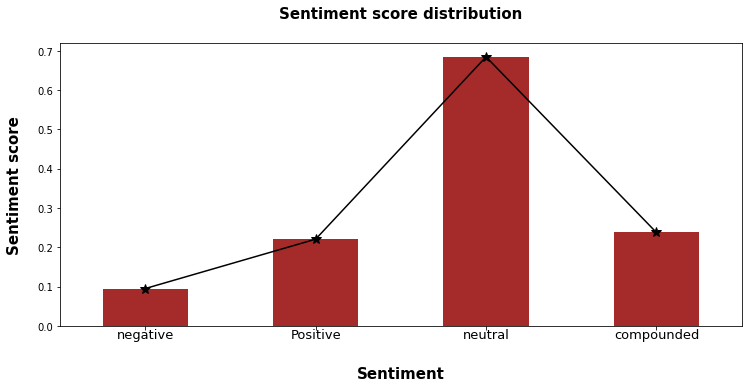

In [ ]:
lst_mean_scores = [df_FandL["neg_sent"].mean(), df_FandL["pos_sent"].mean(), df_FandL["neu_sent"].mean(), df_FandL["comp_sent"].mean()]
plt.rcParams["figure.figsize"] = [10.50, 5.50]
plt.rcParams["figure.autolayout"] = True

df = pd.DataFrame(dict(data=lst_mean_scores))
ax = plt.subplots()

fig=df["data"].plot(kind='bar', color='brown')
fig=df["data"].plot(kind='line', marker='*', color='black', ms=10)
fig.set_title("Sentiment score distribution", pad=25, fontweight="bold", fontdict={'fontsize':15})
fig.set_xlabel('Sentiment',fontdict={'fontsize':15}, labelpad=25, fontweight="bold")
fig.set_ylabel('Sentiment score',fontdict={'fontsize':15}, labelpad=15, fontweight="bold")
fig.set_xticklabels(["negative","Positive","neutral","compounded"], fontdict={'fontsize':13, 'verticalalignment': "center_baseline", 'horizontalalignment': 'center'} )
plt.show()

### Pre Processing for nodeXL
Extract Users from Tweet, Retweet, Mentions and Replies

In [ ]:
df_FairandLovely_10cols = pd.DataFrame(columns=["User1", "User2","ContentType", "User1 Follower Count", "User1 latitude", "User1 longitude", "User2 Follower Count", "User2 latitude", "User2 longitude" ,"Sentiment"])
for index, row in df_FandL.iterrows():    
    #print(index)
    col1=row["Username"]
    col3=row['ContentType']
    col2 = ""   
    col4 = row["User Follower Count"]
    col5 = row["Tweet latitude"]
    col6 = row["Tweet longitude"]
   # col10=row["Date"]
    col10=row["Sentiment"]
    
#     #tweetid=row["Tweet Id"]
#     if row['Retweeted Tweet'] is not None:
#         retweeted_user = row['Retweeted Tweet'].user
#         col2 = retweeted_user.username
#         for j, tweet in enumerate(sntwitter.TwitterSearchScraper('from:'+col2).get_items()):
#             if tweet.user.followersCount!=None:
#                 col7 = tweet.user.followersCount
#                 break
#             else:
#                 col7=np.nan
#         if tweet.coordinates!=None:
#             col8 = tweet.coordinates.latitude 
#             col9 = tweet.coordinates.longitude
#         else:
#             col8 = np.nan
#             col9 = np.nan
        
#         df_FairandLovely_10cols.loc[df_FairandLovely_10cols.shape[0]]= [col1,col2,col3, col4, col5, col6, col7, col8, col9, col10]
#         df_FairandLovely_10cols.loc[df_FairandLovely_10cols.shape[0]]= [col2,col2,'Tweet', col4, col5, col6, col7, col8, col9,col10]
#     el
    if row['Mentioned Users'] is not None:
            for i in row['Mentioned Users']:
                col2 = i.username
                
                try:
                    
                    for j, tweet in enumerate(sntwitter.TwitterSearchScraper('from:'+col2).get_items()):
                        if tweet.user.followersCount!=None:
                            col7 = tweet.user.followersCount
                            break
                        else:
                            col7=np.nan
                        
                    if tweet.coordinates!=None:
                        col8 = tweet.coordinates.latitude 
                        col9 = tweet.coordinates.longitude
                    else:
                        col8 = np.nan
                        col9 = np.nan
                except:
                    col7=np.nan
                    col8=np.nan
                    col9=np.nan
                df_FairandLovely_10cols.loc[df_FairandLovely_10cols.shape[0]]= [col1,col2,col3, col4, col5, col6, col7, col8, col9, col10]
    elif row['Reply To User'] is not None:
            col2 = row['Reply To User'].username
            
            for j, tweet in enumerate(sntwitter.TwitterSearchScraper('from:'+col2).get_items()):
                if tweet.user.followersCount!=None:
                    col7 = tweet.user.followersCount
                    break
                else:
                    col7=np.nan
            if tweet.coordinates!=None:
                col8 = tweet.coordinates.latitude 
                col9 = tweet.coordinates.longitude
            else:
                col8 = np.nan
                col9 = np.nan
            df_FairandLovely_10cols.loc[df_FairandLovely_10cols.shape[0]]= [col1,col2,col3, col4, col5, col6, col7, col8, col9, col10]
    else:
            df_FairandLovely_10cols.loc[df_FairandLovely_10cols.shape[0]]= [col1,col1,col3, col4, col5, col6, col4, col5, col6, col10]            

Error retrieving https://api.twitter.com/2/search/adaptive.json?include_profile_interstitial_type=1&include_blocking=1&include_blocked_by=1&include_followed_by=1&include_want_retweets=1&include_mute_edge=1&include_can_dm=1&include_can_media_tag=1&skip_status=1&cards_platform=Web-12&include_cards=1&include_ext_alt_text=true&include_quote_count=true&include_reply_count=1&tweet_mode=extended&include_entities=true&include_user_entities=true&include_ext_media_color=true&include_ext_media_availability=true&send_error_codes=true&simple_quoted_tweets=true&q=from%3AIyervval&tweet_search_mode=live&count=100&query_source=spelling_expansion_revert_click&pc=1&spelling_corrections=1&ext=mediaStats%2ChighlightedLabel: non-200 status code
4 requests to https://api.twitter.com/2/search/adaptive.json?include_profile_interstitial_type=1&include_blocking=1&include_blocked_by=1&include_followed_by=1&include_want_retweets=1&include_mute_edge=1&include_can_dm=1&include_can_media_tag=1&skip_status=1&cards_pla

Export Data in the format required for Node XL

In [ ]:
df_FairandLovely_10cols.to_csv("FairandLovely_graph_before_data.csv", index=False)

### After Re-branding

In [ ]:
# Calling the sentiment analysis function to calculate the sentiment score of every tweet

lst=[]
for i in df_post_rebranding["Text_clean"]:
    lst.append(sentiment_analyzer_scores(str(i)))


In [ ]:
# Combining all positive, negative, neutral and compound(combined) sentiments together to be added to the dataframe 

dic={}
lst_neg=[]
lst_pos=[]
lst_neu=[]
lst_comp=[]
for i in lst:
    if "neg" in i.keys():
        lst_neg.append(i["neg"])
    if "pos" in i.keys():
        lst_pos.append(i["pos"])
    if "neu" in i.keys():
        lst_neu.append(i["neu"])
    if "compound" in i.keys():
        lst_comp.append(i["compound"])
dic["neg_sent"]=lst_neg
dic["pos_sent"]=lst_pos
dic["neu_sent"]=lst_neu
dic["comp_sent"]=lst_comp
#print(dic)
df_post_rebranding["neg_sent"] =  dic["neg_sent"]
df_post_rebranding["pos_sent"] =  dic["pos_sent"]
df_post_rebranding["neu_sent"] =  dic["neu_sent"]
df_post_rebranding["comp_sent"] =  dic["comp_sent"]

In [ ]:
df_post_rebranding["Sentiment"] = np.where(df_post_rebranding["comp_sent"]< -0.05, "Negative",np.where(df_post_rebranding["comp_sent"]> 0.05, "Positive","Neutral"))

In [ ]:
df_post_rebranding["Sentiment"].value_counts()

Positive    2743
Negative     793
Neutral      697
Name: Sentiment, dtype: int64

We will now split the tweets into 3 time periods; 3 trimesters starting from 25th June, 2020 until 30th April, 2021 to observe the sentiment trend over these trimesters

In [ ]:
# 1st trimester

rebranding_date_1st_trim_sd = "2020-06-25"
rebranding_date_1st_trim_ed = "2020-09-30"
df_post_rebranding_sentiment_trim_1 = df_post_rebranding[(df_post_rebranding.Datetime>rebranding_date_1st_trim_sd) & (df_post_rebranding.Datetime<=rebranding_date_1st_trim_ed)]
df_post_rebranding_sentiment_trim_1.head()

,Datetime,Tweet Id,Text,Username,url,User Location,User Follower Count,User Following Count,User Listed Count,User Posts Count,...,Tweet,Tweet latitude,Tweet longitude,ContentType,Text_clean,neg_sent,pos_sent,neu_sent,comp_sent,Sentiment
138,2020-09-28 18:20:01+00:00,1310645452505784321,Good.Night glow .. #nomakeup #nofilter #nofil...,realistic_rishu,https://twitter.com/realistic_rishu/status/131...,NaN,50,144,0,1502,...,https://twitter.com/realistic_rishu/status/131...,NaN,NaN,Tweet,#goodnight #nofilter glow night http good #nom...,0.0,0.195,0.805,0.4404,Positive
139,2020-09-27 17:23:12+00:00,1310268768409456640,Filters are the modern fair &amp; lovely that...,nirali_shahh,https://twitter.com/nirali_shahh/status/131026...,NaN,213,778,1,989,...,https://twitter.com/nirali_shahh/status/131026...,NaN,NaN,Tweet,later fair filter lovely end sooner modern spi...,0.0,0.504,0.496,0.7269,Positive
140,2020-09-27 12:42:07+00:00,1310198030415527943,What is Lovely for you?\n\nShare your opinion ...,digiecrew,https://twitter.com/digiecrew/status/131019803...,India and United States,430,668,1,549,...,https://twitter.com/digiecrew/status/131019803...,NaN,NaN,Tweet,#colorism co #digiecrew #glow #skinglow #brown...,0.0,0.250,0.750,0.7184,Positive
141,2020-09-25 10:33:59+00:00,1309441009076506625,A wide range of top notch advertisers leverage...,katranjeet,https://twitter.com/katranjeet/status/13094410...,"Bengaluru, India",2108,137,9,15914,...,https://twitter.com/katranjeet/status/13094410...,12.919037,77.373474,NonTweet,pondsindia co reach india top vk parachutecare...,0.0,0.121,0.879,0.2263,Positive
142,2020-09-24 05:53:19+00:00,1309007989702000640,@HUL_News 's Fair and lovely changed it's name...,IamStanRocky,https://twitter.com/IamStanRocky/status/130900...,"Hanamkonda, Warangal-Hamamkond",53,529,0,467,...,https://twitter.com/IamStanRocky/status/130900...,NaN,NaN,NonTweet,changed fair news name pondsindia #justasking ...,0.0,0.466,0.534,0.7269,Positive


In [ ]:
df_post_rebranding_sentiment_trim_1["comp_sent"].mean()

0.3063703847146897

In [ ]:
# 2nd trimester

rebranding_date_2nd_trim_sd = "2020-10-01"
rebranding_date_2nd_trim_ed = "2021-01-31"
df_post_rebranding_sentiment_trim_2 = df_post_rebranding[(df_post_rebranding.Datetime>rebranding_date_2nd_trim_sd) & (df_post_rebranding.Datetime<=rebranding_date_2nd_trim_ed)]
df_post_rebranding_sentiment_trim_2.head()

,Datetime,Tweet Id,Text,Username,url,User Location,User Follower Count,User Following Count,User Listed Count,User Posts Count,...,Tweet,Tweet latitude,Tweet longitude,ContentType,Text_clean,neg_sent,pos_sent,neu_sent,comp_sent,Sentiment
53,2021-01-15 07:16:05+00:00,1349978648703504384,If #GlowAndLovely is using its controversial o...,WannabeSanyasin,https://twitter.com/WannabeSanyasin/status/134...,Bombay. ♥,4333,1548,125,122613,...,https://twitter.com/WannabeSanyasin/status/134...,NaN,NaN,Tweet,sham aware controversial rebranding mar glow p...,0.092,0.194,0.714,0.4588,Positive
54,2020-12-22 05:09:04+00:00,1341249371577274370,【#Girl who corrected “#FairAndLovely” to “#Glo...,eatnews_en,https://twitter.com/eatnews_en/status/13412493...,"California, USA",323,16,2,708,...,https://twitter.com/eatnews_en/status/13412493...,NaN,NaN,Tweet,fair year co corrected lovely #fairness #india...,0.201,0.266,0.533,0.4767,Positive
55,2020-12-13 09:52:27+00:00,1338059199482368000,@HaiderKAbbasi Soon you will see her in #glowa...,afridi792,https://twitter.com/afridi792/status/133805919...,"Karachi, Pakistan",2278,955,0,22740,...,https://twitter.com/afridi792/status/133805919...,24.802239,66.95121,NonTweet,soon see haiderkabbasi,0.000,0.000,1.000,0.0000,Neutral
56,2020-12-12 13:54:45+00:00,1337757788127150081,Fair and lovely to glow and lovely\n\nI hope n...,tweetsbyshree,https://twitter.com/tweetsbyshree/status/13377...,NaN,27,478,0,171,...,https://twitter.com/tweetsbyshree/status/13377...,NaN,NaN,Tweet,file commercial street none malleswaram fair n...,0.233,0.308,0.460,0.3895,Positive
57,2020-12-02 20:39:02+00:00,1334235650904690688,Glad to see that Unilever took criticism const...,speak_JB,https://twitter.com/speak_JB/status/1334235650...,"Lahore, Pakistan",216,290,1,932,...,https://twitter.com/speak_JB/status/1334235650...,NaN,NaN,Tweet,stopped criticism co unilever promoting slim s...,0.356,0.151,0.493,-0.8176,Negative


In [ ]:
df_post_rebranding_sentiment_trim_2["comp_sent"].mean()

0.298172105263158

In [ ]:
# 3rd trimester

rebranding_date_3rd_trim_sd = "2021-01-31"
rebranding_date_3rd_trim_ed = "2021-04-30"
df_post_rebranding_sentiment_trim_3 = df_post_rebranding[(df_post_rebranding.Datetime>rebranding_date_3rd_trim_sd) & (df_post_rebranding.Datetime<=rebranding_date_3rd_trim_ed)]
df_post_rebranding_sentiment_trim_3.head()

,Datetime,Tweet Id,Text,Username,url,User Location,User Follower Count,User Following Count,User Listed Count,User Posts Count,...,Tweet,Tweet latitude,Tweet longitude,ContentType,Text_clean,neg_sent,pos_sent,neu_sent,comp_sent,Sentiment
40,2021-04-13 13:57:17+00:00,1381969745012957186,Sabila Noor is the new face of Glow &amp; Love...,markedium,https://twitter.com/markedium/status/138196974...,NaN,96,413,0,1159,...,https://twitter.com/markedium/status/138196974...,NaN,NaN,Tweet,sabila #newface #unilever glow noor #markedium...,0.000,0.226,0.774,0.5859,Positive
41,2021-04-11 07:28:14+00:00,1381147059684659201,Link to the article - https://t.co/oc6KB2LK54\...,chandana_hiran,https://twitter.com/chandana_hiran/status/1381...,"Mumbai, India",1416,734,4,6158,...,https://twitter.com/chandana_hiran/status/1381...,NaN,NaN,NonTweet,link #allshadesarelovely #sundayvibes #power h...,0.000,0.000,1.000,0.0000,Neutral
42,2021-04-09 05:26:51+00:00,1380391736346734593,Best ad campaign for #FairAndLovely oops sorry...,Sam_Ey_Am,https://twitter.com/Sam_Ey_Am/status/138039173...,Tween Jonstown n Rajnishpuram,14,106,0,2445,...,https://twitter.com/Sam_Ey_Am/status/138039173...,NaN,NaN,Tweet,sorry ad http varfl1pbdc co oops campaign best,0.113,0.365,0.522,0.5994,Positive
43,2021-04-03 01:51:58+00:00,1378163334155923461,"Dear girls do what you like , don't do things ...",Trueind39173507,https://twitter.com/Trueind39173507/status/137...,NaN,3,23,0,373,...,https://twitter.com/Trueind39173507/status/137...,NaN,NaN,NonTweet,#fakefeminim girl #pseudofeminist news yamigau...,0.000,0.298,0.702,0.6249,Positive
44,2021-03-30 11:09:55+00:00,1376854195685322757,This is cool @HUL_News but when will you stop ...,ntashabhardwaj,https://twitter.com/ntashabhardwaj/status/1376...,Goa/New York,658,583,4,2375,...,https://twitter.com/ntashabhardwaj/status/1376...,NaN,NaN,NonTweet,stop making news http ucbvpwqsuz #colorism co ...,0.176,0.184,0.640,0.0258,Neutral


In [ ]:
df_post_rebranding_sentiment_trim_3["comp_sent"].mean()

0.21086315789473692

In [ ]:
df_post_rebranding_sentiment_trim_3["neg_sent"].mean(), df_post_rebranding_sentiment_trim_3["pos_sent"].mean(), df_post_rebranding_sentiment_trim_3["neu_sent"].mean(), df_post_rebranding_sentiment_trim_3["comp_sent"].mean()

(0.0838421052631579,
 0.190561403508772,
 0.7255789473684211,
 0.21086315789473692)

In [1]:
#  Graph for tweets over 4 time periods for fair and lovely and glow and lovely

# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd


# width = .35 # width of a bar

# m1_t = pd.DataFrame({
#  'pre_rebrand' : [df_FandL["neg_sent"].mean(), df_FandL["pos_sent"].mean(), df_FandL["neu_sent"].mean(),df_FandL["comp_sent"].mean()],
#  'tri_1_post' : [df_post_rebranding_sentiment_trim_1["neg_sent"].mean(), df_post_rebranding_sentiment_trim_1["pos_sent"].mean(), df_post_rebranding_sentiment_trim_1["neu_sent"].mean(),df_post_rebranding_sentiment_trim_1["comp_sent"].mean()],
#  'tri_2_post' : [df_post_rebranding_sentiment_trim_2["neg_sent"].mean(), df_post_rebranding_sentiment_trim_2["pos_sent"].mean(), df_post_rebranding_sentiment_trim_2["neu_sent"].mean(),df_post_rebranding_sentiment_trim_2["comp_sent"].mean()],
#  'tri_3_post' : [df_post_rebranding_sentiment_trim_3["neg_sent"].mean(), df_post_rebranding_sentiment_trim_3["pos_sent"].mean(), df_post_rebranding_sentiment_trim_3["neu_sent"].mean(),df_post_rebranding_sentiment_trim_3["comp_sent"].mean()]})

# fig = m1_t[['pre_rebrand','tri_1_post','tri_2_post','tri_3_post']].plot(kind='bar', width = width, color=["brown","olive","gold","mediumaquamarine"])
# # 
# ax = plt.gca()


# fig.set_title("Sentiment scores across pre and post rebranding phases ", pad=25, fontweight="bold", fontdict={'fontsize':12})
# fig.set_xlabel('Phases',fontdict={'fontsize':12}, labelpad=25, fontweight="bold")
# fig.set_ylabel('Sentiment score',fontdict={'fontsize':12}, labelpad=15, fontweight="bold")
# fig.set_xticklabels(m1_t.columns, fontdict={'fontsize':10, 'verticalalignment': "center_baseline", 'horizontalalignment': 'center'} )

# L=plt.legend()
# L.get_texts()[0].set_text('negative sentiment score')
# L.get_texts()[1].set_text('positive sentiment score')
# L.get_texts()[2].set_text('neutral sentiment score')
# L.get_texts()[3].set_text('compounded sentiment score')

# plt.show()

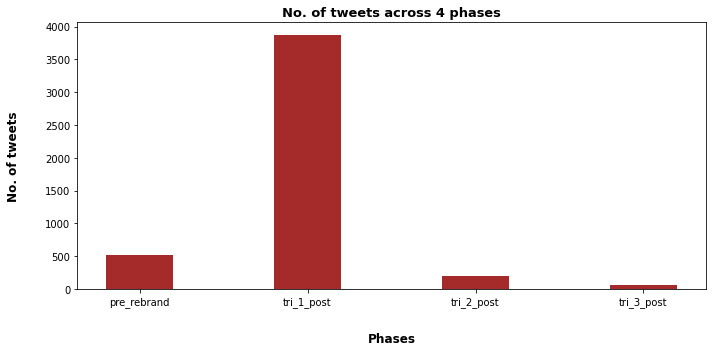

In [ ]:
# No. of tweets across 3 time periods plot

data = {'pre_rebrand' : df_FandL["Text_clean"].count(), 
        'tri_1_post' : df_post_rebranding_sentiment_trim_1["Text_clean"].count(),
        'tri_2_post' : df_post_rebranding_sentiment_trim_2["Text_clean"].count(),
        'tri_3_post' : df_post_rebranding_sentiment_trim_3["Text_clean"].count()}
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='brown',
        width = 0.4)


plt.xlabel("Phases",fontdict={'fontsize':12}, labelpad=25, fontweight="bold")
plt.ylabel("No. of tweets",fontdict={'fontsize':12}, labelpad=25, fontweight="bold")
plt.title("No. of tweets across 4 phases",fontdict={'fontsize':13}, fontweight="bold")
plt.show()




### Pre Processing for nodeXL
Extract Users from Tweet, Retweet, Mentions and Replies

In [ ]:
df_GlowandLovely_10cols = pd.DataFrame(columns=["User1", "User2","ContentType", "User1 Follower Count", "User1 latitude", "User1 longitude", "User2 Follower Count", "User2 latitude", "User2 longitude","Sentiment"])
for index, row in df_post_rebranding.iterrows():    
    #print(index)
    col1=row["Username"]
    col3=row['ContentType']
    col2 = ""   
    col4 = row["User Follower Count"]
    col5 = row["Tweet latitude"]
    col6 = row["Tweet longitude"]
    col10=row["Sentiment"]
    
    tweetid=row["Tweet Id"]
    if row['Retweeted Tweet'] is not None:
        retweeted_user = row['Retweeted Tweet'].user
        col2 = retweeted_user.username
        for j, tweet in enumerate(sntwitter.TwitterSearchScraper('from:'+col2).get_items()):
            if tweet.user.followersCount!=None and tweet.lang=='en':
                col7 = tweet.user.followersCount
                break
            else:
                col7=np.nan
        if tweet.coordinates!=None:
            col8 = tweet.coordinates.latitude 
            col9 = tweet.coordinates.longitude
        else:
            col8 = np.nan
            col9 = np.nan
        
        df_GlowandLovely_10cols.loc[df_GlowandLovely_10cols.shape[0]]= [col1,col2,col3, col4, col5, col6, col7, col8, col9,col10]
        df_GlowandLovely_10cols.loc[df_GlowandLovely_10cols.shape[0]]= [col2,col2,'Tweet', col4, col5, col6, col7, col8, col9,col10]
    elif row['Mentioned Users'] is not None:
            for i in row['Mentioned Users']:
                col2 = i.username
                
                try:
                    
                    for j, tweet in enumerate(sntwitter.TwitterSearchScraper('from:'+col2).get_items()):
                        if tweet.user.followersCount!=None and tweet.lang=='en':
                            col7 = tweet.user.followersCount
                            break
                        else:
                            col7=np.nan
                        
                    if tweet.coordinates!=None:
                        col8 = tweet.coordinates.latitude 
                        col9 = tweet.coordinates.longitude
                    else:
                        col8 = np.nan
                        col9 = np.nan
                except:
                    col7=np.nan
                    col8=np.nan
                    col9=np.nan
                    pass
                df_GlowandLovely_10cols.loc[df_GlowandLovely_10cols.shape[0]]= [col1,col2,col3, col4, col5, col6, col7, col8, col9,col10]
    elif row['Reply To User'] is not None:
            col2 = row['Reply To User'].username
            
            for j, tweet in enumerate(sntwitter.TwitterSearchScraper('from:'+col2).get_items()):
                if tweet.user.followersCount!=None and tweet.lang=='en':
                    col7 = tweet.user.followersCount
                    break
                else:
                    col7=np.nan
            if tweet.coordinates!=None:
                col8 = tweet.coordinates.latitude 
                col9 = tweet.coordinates.longitude
            else:
                col8 = np.nan
                col9 = np.nan
            df_GlowandLovely_10cols.loc[df_GlowandLovely_10cols.shape[0]]= [col1,col2,col3, col4, col5, col6, col7, col8, col9,col10]
    else:
            df_GlowandLovely_10cols.loc[df_GlowandLovely_10cols.shape[0]]= [col1,col1,col3, col4, col5, col6, col4, col5, col6,col10]            

Export Data in the format required for Node XL

In [ ]:
df_GlowandLovely_10cols.to_csv("GlowandLovely_graph_data_after.csv", index=False)